In [ ]:
import tensorflow as tf
import os
# Define image size and batch size
IMG_SIZE = (160, 160)  # Resize images to 160x160
BATCH_SIZE = 32

# Define paths
dataset_path = '../anamelClassification.v1i.multiclass'
# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_path, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 400 files belonging to 4 classes.
Found 50 files belonging to 4 classes.
Found 50 files belonging to 4 classes.


In [2]:
# Load the EfficientNetB0 base model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(160, 160, 3),
                                                  include_top=False,
                                                  weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of EfficientNet
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),  # Regularization
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

# Train the model
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 960ms/step - loss: 1.2670 - sparse_categorical_accuracy: 0.3753 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.6600
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 478ms/step - loss: 0.7678 - sparse_categorical_accuracy: 0.6620 - val_loss: 0.5396 - val_sparse_categorical_accuracy: 0.8200
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 537ms/step - loss: 0.5488 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.4395 - val_sparse_categorical_accuracy: 0.8800
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - loss: 0.4101 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.3735 - val_sparse_categorical_accuracy: 0.9000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 0.3800 - sparse_categorical_accuracy: 0.8910 - val_loss: 0.3374 - val_sparse_categorical_accuracy: 0.9000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - loss: 0.3210 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.3081 - val_sparse_categorical_accuracy: 0.8800
Epo

In [3]:

# Unfreeze the base model for fine-tuning
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model for fine-tuning
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),  # Lower learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

Number of layers in the base model:  238


In [10]:
# Fine-tune for a few more epochs
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# Fit the model with the fine-tuning
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],  # Start from the last epoch of previous training
                         validation_data=valid_dataset)



Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 0.8071 - sparse_categorical_accuracy: 0.7031 - val_loss: 0.2537 - val_sparse_categorical_accuracy: 0.9200
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.7571 - sparse_categorical_accuracy: 0.7331 - val_loss: 0.2617 - val_sparse_categorical_accuracy: 0.9200
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.7291 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.2763 - val_sparse_categorical_accuracy: 0.9200
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.6673 - sparse_categorical_accuracy: 0.8164 - val_loss: 0.2895 - val_sparse_categorical_accuracy: 0.9400
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.6250 - sparse_categorical_accuracy: 0.8278 - val_loss: 0.3025 - val_sparse_categorical_accuracy: 0.9600
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.5709 - sparse_categorical_accuracy: 0.8327 - val_loss: 0.3132 - val_sparse_categorical_accuracy: 0.9600
Epoch 16/2

In [12]:
# Evaluate on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - loss: 0.4346 - sparse_categorical_accuracy: 0.8650
Test Accuracy: 0.8600
Test Loss: 0.4633


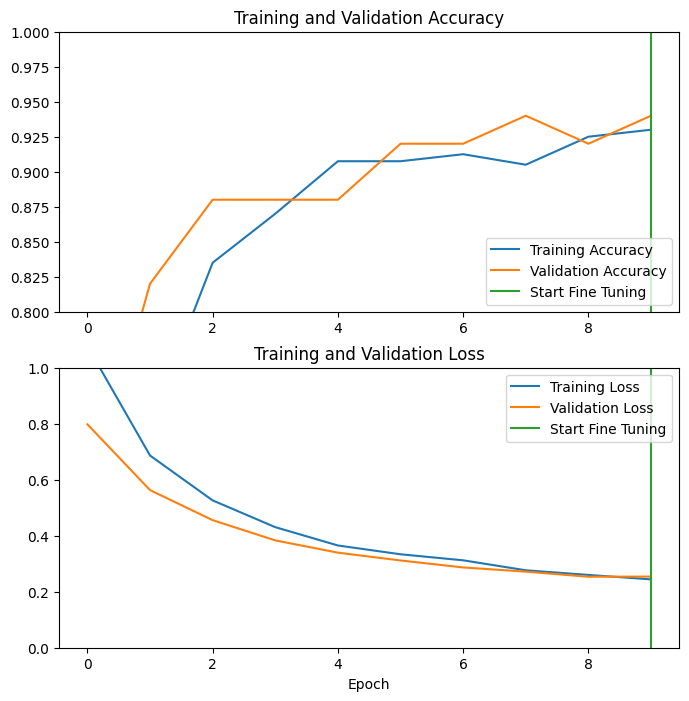

In [17]:
# Plot the training and validation accuracy and loss
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(8, 8))

# Accuracy Plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()




Found 50 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


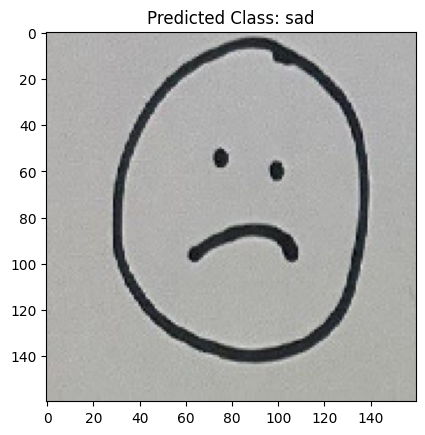

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Create the test generator (assuming 'test' folder is correct)
test_data = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test = test_data.flow_from_directory('../anamelClassification.v1i.multiclass/test', 
                                     target_size=(160, 160), 
                                     batch_size=32, 
                                     class_mode='categorical')

# Get one batch from the generator
image_batch, label_batch = next(test)

# Pick the first image in the batch
image = image_batch[0]
label = label_batch[0]

# Get the class names from the generator
class_names = list(test.class_indices.keys())

# Make a prediction
predicted_class_index = np.argmax(model.predict(np.expand_dims(image, axis=0)))

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Display the image with the predicted class name as title
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()


In [ ]:
model.save('EfficientNetB0.h5')